###Imports Required Libraries

In [1]:
import pandas as pd
# this is to work interactively work on jupyter notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

###Get The Data


In [2]:
#read the data 
housing = pd.read_csv('/content/housing.csv')

###Take a quick look at the data structure

In [3]:
# first five rows of data
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
#quick info
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


##### there are 20640 districts(instances or rows) and in **total_bedrooms** column there are 20433 rows, we will deal with missing data later.
in **ocean_proximity** column is objects so it could be any python data type but it is text data as we getting data from csv

In [5]:
#describe the dataset
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


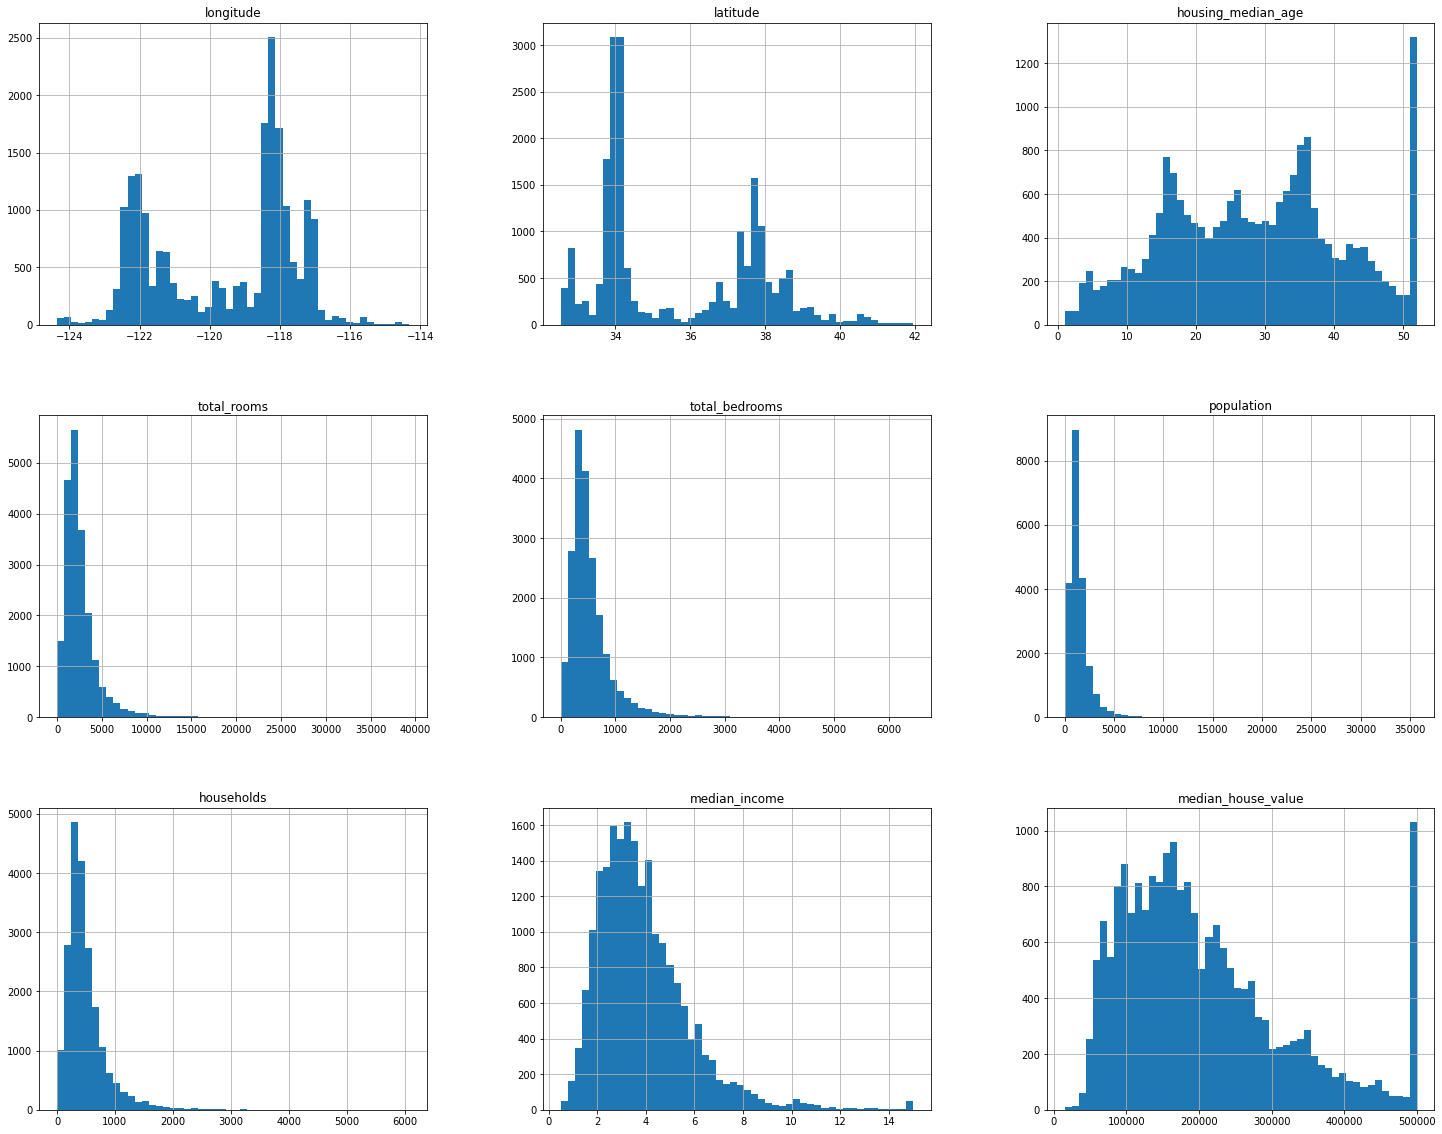

In [6]:
# draw histograms on entire dataset

housing.hist(bins=50, figsize=(25,20))
plt.show()

By using this housing data we have to find median house value

labels:- **housing data** expect *median_housing_value*

features:- **median_housing_value**

###Create a Test Set

In [7]:
def split_train_test(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data)*test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)

Well this work but there are some expection will raise

1) when we run this model there will new come to train and test sets, that shouldn't be if the data is keep on changing model will see entire data by the time

2) what if new data (new set or new rows) comes in

Here is possible implementation

In [8]:
def test_set_check(identifier, test_ratio):
  return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2 * 32 

In [9]:
def split_train_test_by_id(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_ : test_set_check(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

In [10]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [11]:
# we can even have different id's using langitude and lattitude

housing_with_id['id'] = housing['latitude'] + 1000 + housing['longitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

### so this is all big process to split data into two parts and 
### there is scikit learn library providing beautiful fuctions to split them apart

##Using Scikit Learn 

In [12]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=52)

In [13]:
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0,1.5,3, 4.5, 6, np.inf],
                               labels=[1,2,3,4,5])
housing['income_cat']

0        5
1        5
2        5
3        4
4        3
        ..
20635    2
20636    2
20637    2
20638    2
20639    2
Name: income_cat, Length: 20640, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

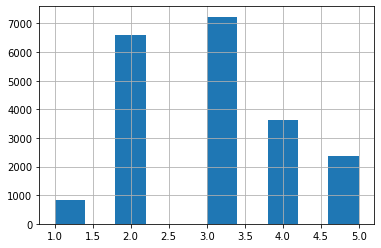

In [14]:
housing['income_cat'].hist()

In [15]:
# train_test_split function usually used for large datasets but for smaller dataset there is always alternative
# i.e., StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=52)
for train_index, test_index in split.split(housing, housing['income_cat']):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]
  

In [16]:
len(strat_test_set)

4128

In [17]:
len(strat_train_set)

16512

In [18]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)


3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [19]:
# lets remove income_cat column

for set_ in (strat_test_set, strat_train_set):
  set_.drop("income_cat", axis=1, inplace=True)

In [20]:
strat_train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5864,-118.34,34.18,45.0,3046.0,633.0,1448.0,599.0,3.2400,226900.0,<1H OCEAN
4350,-118.37,34.11,42.0,5518.0,979.0,1863.0,957.0,8.5842,500001.0,<1H OCEAN
10745,-117.91,33.61,36.0,3082.0,455.0,771.0,365.0,11.2160,500001.0,<1H OCEAN
618,-122.15,37.73,45.0,3758.0,819.0,1573.0,736.0,2.8355,245400.0,NEAR BAY
7169,-118.18,34.06,33.0,278.0,71.0,266.0,56.0,0.8941,98200.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
10049,-120.99,39.13,14.0,770.0,116.0,285.0,116.0,3.6434,155400.0,INLAND
15650,-122.41,37.80,52.0,1999.0,642.0,1846.0,620.0,1.9145,225000.0,NEAR BAY
8834,-118.37,34.09,22.0,4247.0,1253.0,1766.0,1170.0,3.1517,341700.0,<1H OCEAN
12685,-121.40,38.53,38.0,152.0,30.0,65.0,35.0,0.9274,67500.0,INLAND


###Visualize the Data

In [21]:
# taking copy of the data to don't distrub the original data
housing = strat_train_set.copy()

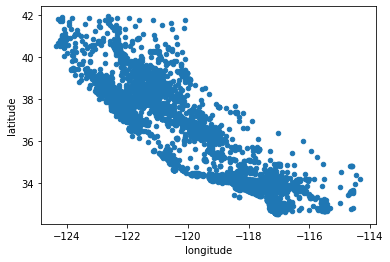

In [22]:
housing.plot(kind="scatter", x="longitude", y='latitude')

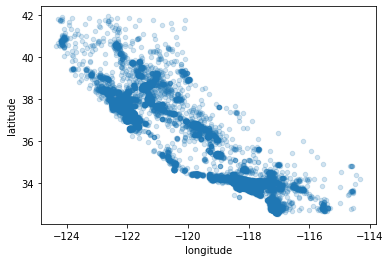

In [23]:
housing.plot(kind="scatter", x="longitude", y='latitude', alpha=0.2)

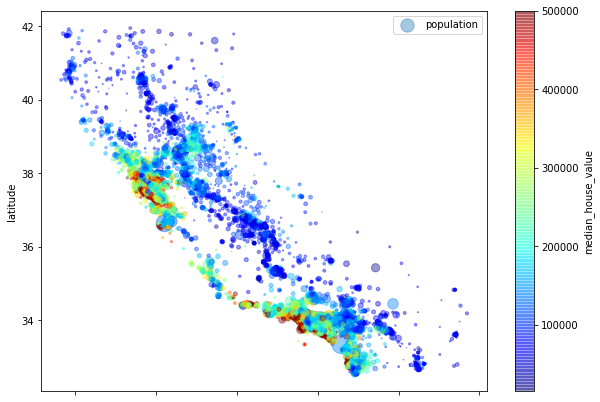

In [24]:
housing.plot(kind="scatter", x="longitude", y='latitude', alpha=0.4,
             s=housing['population']/100, label = "population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap('jet'), colorbar=True
             )
plt.legend()

In [25]:
# use corr() methods to know diffrence between every attribute

corr_matrix = housing.corr()

In [26]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924893,-0.108106,0.044616,0.071680,0.098545,0.055840,-0.020587,-0.051144
latitude,-0.924893,1.000000,0.012467,-0.034361,-0.067184,-0.106626,-0.070546,-0.074447,-0.138525
housing_median_age,-0.108106,0.012467,1.000000,-0.364241,-0.323741,-0.297245,-0.306518,-0.118260,0.102662
total_rooms,0.044616,-0.034361,-0.364241,1.000000,0.930726,0.853973,0.917643,0.194526,0.131950
total_bedrooms,0.071680,-0.067184,-0.323741,0.930726,1.000000,0.873738,0.978565,-0.010324,0.046469
population,0.098545,-0.106626,-0.297245,0.853973,0.873738,1.000000,0.904712,0.004168,-0.025019
households,0.055840,-0.070546,-0.306518,0.917643,0.978565,0.904712,1.000000,0.011031,0.063762
median_income,-0.020587,-0.074447,-0.118260,0.194526,-0.010324,0.004168,0.011031,1.000000,0.687934
median_house_value,-0.051144,-0.138525,0.102662,0.131950,0.046469,-0.025019,0.063762,0.687934,1.000000


if you observe there is a good relation betweeen ***median_house_value*** and ***median_income***, since our labels is median_house_value we are looking     correlation for that column only

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8f29c02c90>,
      dtype=object)

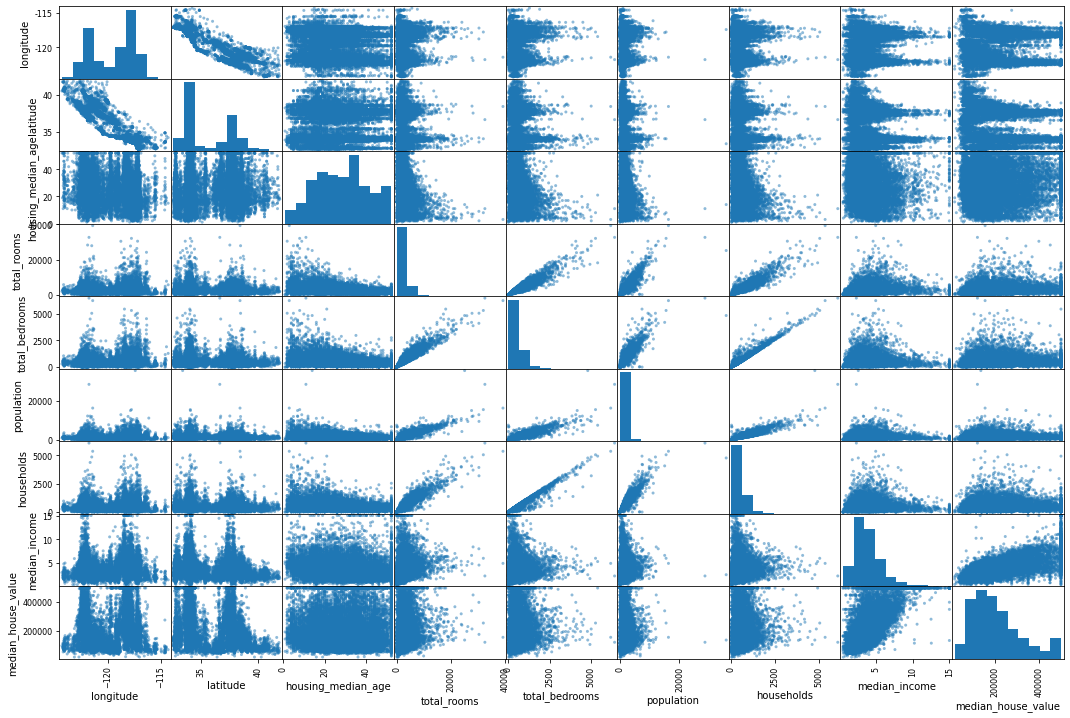

In [27]:
# we can even see this relation visually using scatter matrix

attributes = list(housing.columns)
scatter_matrix(housing[attributes], figsize=(18,12))

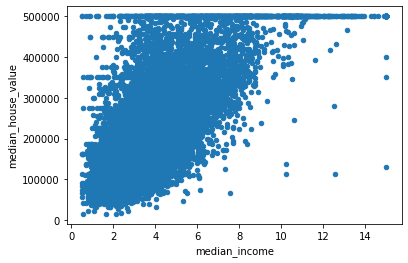

In [28]:
# we can even see particular graph

housing.plot(kind="scatter", x="median_income", y="median_house_value")

###Experiment with Attribute Combinations


In [29]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']



In [30]:
# now take a look at correlation how these new attributes are correlated with median_house_value
corr_new_matrix = housing.corr()
corr_new_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687934
rooms_per_household         0.151217
total_rooms                 0.131950
housing_median_age          0.102662
households                  0.063762
total_bedrooms              0.046469
population_per_household   -0.021644
population                 -0.025019
longitude                  -0.051144
latitude                   -0.138525
bedrooms_per_room          -0.257517
Name: median_house_value, dtype: float64

##Prepare the Data for Model

Before cleaning up everything we need take a copy of **features** and **labels** of ***training set***

In [31]:
housing = strat_train_set.drop("median_house_value", axis=1) # except median_house_value
housing_labels = strat_train_set['median_house_value'].copy()

###1)Data Cleaning

####Handling missing values manually

There are three options to handle with missing data

1) Get rid of corresponding districts (delete rows which are missing or nan)

2) Get rid of the whole attribute (delete column which are having missing or nan)

3) Set the values to some value (zeros, mean, mode, median..etc)

In [32]:
# i will choose third option but have a look at 1st and 2nd code too
# housing.dropna(subset=["total_bedrooms"])  #option 1
# housing.drop("total_bedrooms", axis=1)  #option 2
median = housing['total_bedrooms'].median()  #option 3
housing['total_bedrooms'].fillna(median, inplace=True)

####Handling missing values using scikit learn libraries
SKleaen Provides a handy class to take care of missing values called **SimpleImputer**


In [33]:
imputer = SimpleImputer(strategy="median")

Since the median can only be computed on numerical attributes, you need to cretae a copy of the data without the text attributes ***ocean_proximity***

In [34]:
housing_num = housing.drop('ocean_proximity', axis=1)

now let's fit imputer instance to the training data using ***fit()*** methods

In [35]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [36]:
imputer.statistics_

array([-118.48  ,   34.25  ,   29.    , 2127.    ,  435.    , 1166.    ,
        409.    ,    3.5403])

In [37]:
housing_num.median().values

array([-118.48  ,   34.25  ,   29.    , 2127.    ,  435.    , 1166.    ,
        409.    ,    3.5403])

Now you can use this "trained" imputer instance to transform the training set by replacing missing values with the learned medians

---> it is not replaced yet but using transform() method we can replace perminently 

In [38]:
X = imputer.transform(housing_num)

the result of transform method is numpy array. if we want to put it back to pandas DataFrame it's simple

In [39]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [40]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
5864,-118.34,34.18,45.0,3046.0,633.0,1448.0,599.0,3.2400
4350,-118.37,34.11,42.0,5518.0,979.0,1863.0,957.0,8.5842
10745,-117.91,33.61,36.0,3082.0,455.0,771.0,365.0,11.2160
618,-122.15,37.73,45.0,3758.0,819.0,1573.0,736.0,2.8355
7169,-118.18,34.06,33.0,278.0,71.0,266.0,56.0,0.8941


In [41]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 5864 to 16003
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


###2)Handling Text and Categorical Attributes

In [42]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
5864,<1H OCEAN
4350,<1H OCEAN
10745,<1H OCEAN
618,NEAR BAY
7169,<1H OCEAN
19445,INLAND
9897,NEAR BAY
18247,NEAR BAY
432,NEAR BAY
8776,<1H OCEAN


it's not attribute text: there are a limited number of possible values, each of which represents a category. so this attributes is a categorical attribute. Most ML Algos prefer to work with numbers, so let's convert them into categories from text to numbers. for this we can use SKlearn's ***OrdinalEncoder*** class

In [43]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoder = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoder[:10]

array([[0.],
       [0.],
       [0.],
       [3.],
       [0.],
       [1.],
       [3.],
       [3.],
       [3.],
       [0.]])

check categories

In [44]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algos will assume that two nearby values are more similar than two distant values.
This may be fine in some cases but ocean_proximity is not. for eg: categories 0 and 5 are clearly more similar than categories 0 and 1.

To Fix this issue, **common solution is create one binary attribute per category** one attribute is equal to 1 when the category is "<1H OCEAN" (and 0 otherwise), another attribute is equal to 1 when category is "INLAND" (and 0 otherwise) and so on. this is called ***one-hot encoding.*** because only one attribute is equal to 1 (hot), while other will be zero (cold).

Sklearn provides a **OneHotEncoder** Class to convert categorical values into one hot vectors.

In [45]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Output of above code is scipy sparse matrix, instead of numpy array we can convert them into array using **toarray()** method

In [46]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

check categories of one hot encoder

In [47]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

###3)Custom Transformers

Although Sklearn providers many useful transformers, you will need to write your own for task such as custom cleanup operations or combining specific attributes. all you need to create a class and implement three methods: fit(), transform() and fit_transform()

In [48]:
# for example here is a small transformer class that adds the combined attributes
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room=True):
    self.add_bedrooms_per_room = add_bedrooms_per_room
  def fit(self, X, y=None):
    return self # returns nothing
  def transform(self, X, y=None):
    rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
    population_per_household = X[:, population_ix] / X[:, households_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
      return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
    else:
      return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)


###4)Feature Scaling

One of the most important transformations you need to apply to your data is ***feature scaling.*** with few exceptions, ML algos don't perform well when the input numerical attributes have very differernt scales. This is the case for the housing data:the total number of rooms ranges from about 6 to 39320, while the median income only range from 0 to 15. Note that scaling is not required for the target values.

There are two common ways to get all attributes to have the same scale: *min-max scalling* and *standardization*

**Min-Max Scaling:-** many people call this *normalization* is the simplest, values shifted and rescaled so that they endup randing from 0 and 1. we do this by subtracting min value and dividing by the max and the min
>min-max scaling = (x - min)/(max - min, 
where x is input value

SKlearn provides a transformer called *MinMaxScaler* for this. it has a feature_range hyperparameter that let's you  change the range if, for some reason,we don't want 0-1.

**Standardization:-** is different. first it subtract mean value (so standardized values always have zero mean), and then it divides by the standard deviation so that the resulting distribution had unit variance. Unlike min-max scaling, standardization does not boound values to specific range, which may be a problem for some algorithms (eg; neural networks often expect an input value ranging from 0 to 1). However, standardization is much less affected by outliers. For Example, suppose a district had a median income equal to 100 (by mistake). Min-max scaling would then crush all the other values from 0-15 down to 0-0.15, whereas standardization would not be much affected.
>(x-mean)/ standard_deviation, where x is input

Sklearn provides a transformer called *StandardScaler* for standardization.

###5) Transformation Pipelines

As we saw, there are many data transformation steps that need to be executed in the correct order. Fortunstely, SK-Learn provides the **pipeline** class to help with such sequences of transformations. Here is a small pipeline for the numerical attributes.



In [49]:
num_pipeline = Pipeline([
                         ('imputer',SimpleImputer(strategy="median")),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)


The Pipeline constructor take list of name/estimator pairs defining a sequence of steps. All but the last estimator must be transformers (i.e., they must have a fit_transform() method). The names can be anything you like as long as they are unique and don't contain double underscores,__. they will come handy for hyperparameter

fit_tranform() sequentially on all transformers, passing the output of each call as the parameter to the next call untill it reaches the final estimator, for which it calls the fit() method.

The pipeline exposes the same methods as the final estimator. in this example, the last estimator is a StandardScaler, which is a transformer, so the pipeline has a transform() method that applies all the transforms to the data in sequence (and of course also a fit_transform() method, which is the one we used).

So far, we have handled the categorical columns and the numerical columns separately. it would be more convenient to have a single transformer anle to handle all columns =, applying the appropriate transformations to each column. so for Sklearn provides ColumnTransformer for this purpose.

In [50]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
                                   ("num", num_pipeline, num_attribs),
                                   ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)


##Select and Train a Model
Ahh.. finally..!, we framed the problem,got the data and explored it, sampled trainig set and test set, wrote transformation pipelines to clean up ans prepare data for ML algo automatically. we are now ready to select model and train a ML model

###Training and Evaluating on the Training Set

In [51]:
# lets train on linear regression model.
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [52]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
#prediction 
predictions = lin_reg.predict(some_data_prepared)
#labels
labels = list(some_labels)

In [53]:
print(predictions)
print(labels)
((labels-predictions)/labels)*100

[224446.10860451 462294.92082203 529554.50662762 230425.78842207
 102489.85824502]
[226900.0, 500001.0, 500001.0, 245400.0, 98200.0]


array([ 1.08148585,  7.54120075, -5.9106895 ,  6.10196071, -4.36849108])

Let's measure this regression model RMSE on the whole training set using SKlearn mean_squared_error()

In [54]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
print(housing_predictions)
print(housing_labels)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

[224446.10860451 462294.92082203 529554.50662762 ... 272189.40469222
  36530.21820964 171318.95318599]
5864     226900.0
4350     500001.0
10745    500001.0
618      245400.0
7169      98200.0
           ...   
10049    155400.0
15650    225000.0
8834     341700.0
12685     67500.0
16003    313400.0
Name: median_house_value, Length: 16512, dtype: float64


68548.0664009275

In [55]:
# let's train on DecisionRegressor. this is powerful model, capable of finding complex nonlinear 
#relationships in the data

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared,housing_labels)


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [56]:
# let's evaluate
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

wait what no error at all? could this model really perfect, this model badly overfit the data. how can we be sure? we set aside test data untill you ready to launch a model you are confident about. so we need to use part of training set for training and part of it for model validation.

###Better Evaluation Using Cross - Validation
One way to evaluate the decision tree model would be to use the train_test_split() function to split the training set into a smaller training ser and a validation set, then train your models against the smaller training ser and evaluate them against validation set. it is a bit of work. but nothing too dificult it would work  fairly well.

a great alternative is to use SKlearn K-fold cross validation feature.this following code randomly splits the training set into 10 distincts substes called folds, then it trains and evaluate the decision tree model 10 times, picking a different fold for evaluating every time and training on every 9 folds.the result is an array containig the 10 evaluation scores

In [57]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [58]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ",scores.std())

display_scores(tree_rmse_scores)

Scores:  [68410.9198998  74554.18974897 68782.40777745 72087.41085344
 71141.48458694 66890.44767906 75961.05452163 69996.40931897
 70188.5456395  71148.72490438]
Mean:  70916.15949301556
Standard Deviation:  2618.659151653704
